# Un semplice confronto tra comportamento programmato e comportamento appreso

Luca Mari, gennaio 2025  

Quest'opera è distribuita con <a href="http://creativecommons.org/licenses/by-nc-sa/4.0" target="_blank">Licenza Creative Commons Attribuzione - Non commerciale - Condividi allo stesso modo 4.0 Internazionale</a>.  
<img src="https://creativecommons.it/chapterIT/wp-content/uploads/2021/01/by-nc-sa.eu_.png" width="100">

**Obiettivo**: a partire da un esempio elementare -- un problema di regressione lineare semplice -- comprendere le differenze fondamentali tra sistemi a comportamento programmato (_"programmed machines"_) e sistemi a comportamento appreso (_"learned machines"_).  
**Precompetenze**: basi di Python; almeno qualche idea di analisi matematica.

> Per eseguire questo notebook con VSCode sul proprio calcolatore, occorre:
> * installare un interprete Python
> * scaricare da https://code.visualstudio.com/download e installare VSCode
> * eseguire VSCode e attivare le estensioni per Python e Jupyter
> * ancora in VSCode:
>     * creare una cartella di lavoro e renderla la cartella corrente
>     * copiare nella cartella il file di questa attività: [linear.ipynb](linear.ipynb)
>     * aprire il notebook `linear.ipynb`
>     * creare un ambiente virtuale locale Python (Select Kernel | Python Environments | Create Python Environment | Venv, e scegliere un interprete Python):
>     * installare i moduli Python richiesti, eseguendo dal terminale:  
>         `pip install numpy matplotlib torch ipywidgets`

Supponiamo di disporre di un insieme di coppie di numeri $\{(x_i, y_i)\}$, e da questo, per ogni nuovo $x$, di voler trovare l'$y$ più coerente con il contenuto dell'insieme. Si tratta dunque di un problema _data driven_, che ci richiede di trovare un _modello_ in grado di interpretare la relazione tra le due variabili $x$ e $y$.

Una scelta molto semplice per tale modello è di considerare $x$ e $y$ come le coordinate di una retta, dunque in relazione attraverso l'equazione $y = k_0 + k_1 x$, cioè una funzione $y = f(x; k_0, k_1)$ a due parametri, $k_0$ e $k_1$, di cui dobbiamo stimare i valori. Si tratta di un problema noto in statistica come _regressione lineare_.

In altri termini, il modello che abbiamo assunto ha una _struttura_ –- data dall’ipotesi che la relazione tra $x$ e $y$ sia lineare – che però non identifica completamente il modello, dato il fatto che ci sono infinite funzioni lineari, cioè infinite rette, al variare dei valori dei parametri $k_0$ e $k_1$: il nostro problema è perciò di trovare i valori di $k_0$ e $k_1$ che corrispondono alla retta che meglio interpreta i dati nell'insieme $\{(x_i, y_i)\}$.

Risolveremo questo problema in accordo a due strategie alternative, implementando prima una soluzione "a comportamento programmato", dunque con una _"programmed machine"_, e poi una soluzione "a comportamento appreso", dunque con una _"learned machine"_.

Importiamo prima di tutto i moduli Python necessari.

In [9]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.animation
from ipywidgets import interact, FloatSlider

Generiamo ora sinteticamente l'insieme di coppie di numeri $\{(x_i,y_i)\}$ da interpretare per stimare i valori dei parametri del modello. Supponiamo che ogni coppia sia effettivamente disposta su una retta, a meno di un po' di "rumore", dunque $y_i = a + bx_i + r_i$, dove assumiamo che $r_i$ sia un numero casuale a distribuzione gaussiana con media $0$. Quindi visualizziamo i punti dell'insieme.

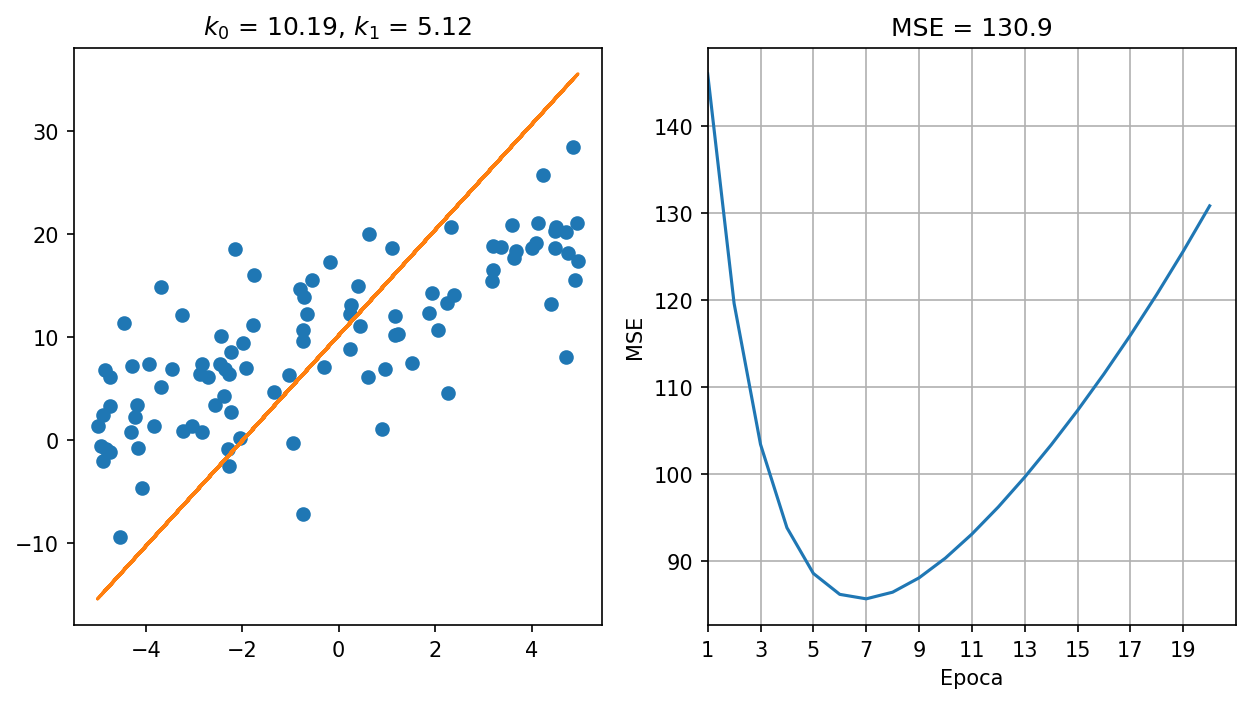

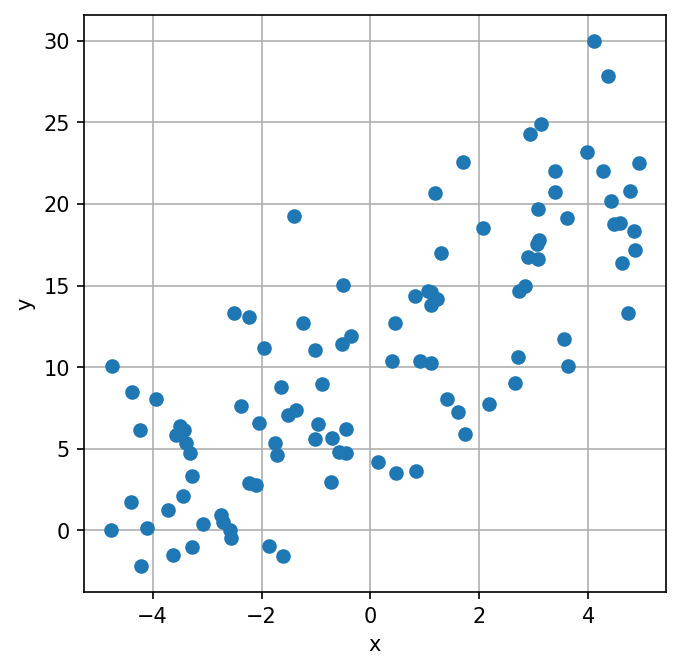

In [10]:
num_coppie = 100                            # numero di coppie di punti (x_i, y_i) da generare
k0_vero = 10.0                              # valore vero, che tratteremo come ignoto e da stimare, del parametro k0
k1_vero = 2.0                               # valore vero, che tratteremo come ignoto e da stimare, del parametro k1
X = 10 * np.random.rand(num_coppie) - 5     # numeri casuali a distribuzione uniforme tra -5 e 5
Y = k0_vero + k1_vero * X + 5 * np.random.randn(num_coppie) # y = 3x + 4 + errore gaussiano a media 0 e deviazione standard 5

fig_size = (5, 5)
plt.figure(figsize=fig_size)
plt.plot(X, Y, 'o')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()

Il problema di stimare i valori dei parametri $k_0$ e $k_1$ di una funzione lineare viene generalmente interpretato in accordo alla tecnica “dei minimi quadrati”, nota da molto tempo e basata sull'ipotesi che i valori in questione siano quelli che minimizzano la distanza della retta che stiamo cercando dai punti dell'insieme, valutata minimizzando la _funzione di errore_ (_loss function_) definita come la media $\overline{r_i^2}$ dei valori $r_i$ elevati al quadrato per evitare che valori positivi e negativi si compensino.

Potremmo cercare di risolvere il problema variando manualmente i valori dei due parametri per cercare i valori che minimizzano la funzione di errore.

In [6]:
def straight_line(slope, intercept):
    x = np.linspace(-10, 10, 10)            # coordinate x della retta
    y = intercept + x * slope               # coordinate y della retta
    mse = np.mean(((intercept + X * slope) - Y) ** 2) # funzione di errore da minimizzare
    
    plt.figure(figsize=fig_size)
    plt.plot(X, Y, 'o')
    plt.plot(x, y)
    plt.title(f'MSE = {mse:.1f}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim(-5, 5)
    plt.ylim(-20, 30)
    plt.grid(True)
    plt.show()

interact(straight_line,
    slope=FloatSlider(value=1, min=-5, max=5.0, step=0.1, description='k_1: pendenza'),
    intercept=FloatSlider(value=0, min=-20, max=20, step=0.1, description='k_0: intercetta')
)

print()

interactive(children=(FloatSlider(value=1.0, description='k_1: pendenza', max=5.0, min=-5.0), FloatSlider(valu…

Evidentemente, questa strategia non è efficiente né garantisce di trovare la soluzione migliore. Proseguiamo allora, introducendo prima una soluzione a comportamento programmato e poi una soluzione a comportamento appreso.

### Una soluzione "a comportamento programmato"

La funzione di errore, di cui occorre dunque cercare il minimo, è sufficientemente semplice perché esista una soluzione analitica, nella forma di formule algebriche. Si tratta allora di ricavare, o recuperare, le formule in questione, che sono:  
$$k_1 = \frac{\sum_i (x_i - \bar x)(y_i - \bar y)}{\sum_i (x_i - \bar x)^2}$$
$$k_0 = \bar y - k_1 \bar x$$
dove $\bar x$ è il valor medio degli $x_i$, e calcolarle per ottenere la stima di $k_0$ e $k_1$.

Implementiamo queste formule (non sorprendentemente, potremmo anche usare una versione già implementata, per esempio nel metodo `polyfit` di `numpy`).

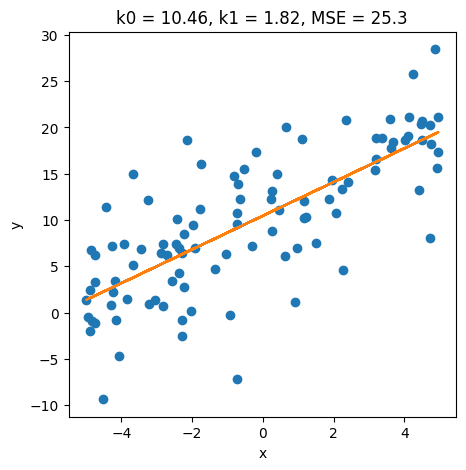

In [7]:
x_medio = np.mean(X)
y_medio = np.mean(Y)
k1 = (np.sum((X - x_medio) * (Y - y_medio))) / np.sum((X - x_medio) ** 2)
k0 = y_medio - k1 * x_medio
mse = np.mean((k0 + k1 * X - Y) ** 2)

plt.figure(figsize=fig_size)
plt.plot(X, Y, 'o')
plt.plot(X, k0 + k1 * X)
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'k0 = {k0:.2f}, k1 = {k1:.2f}, MSE = {mse:.1f}')
plt.show()

Questa è dunque una soluzione a comportamento programmato: esseri umani identificano una procedura per risolvere il problema, la implementano in software, e fanno eseguire il programma così ottenuto a un calcolatore.

### Una soluzione "a comportamento addestrato"

Una strategia alternativa alla precedente per risolvere il problema di trovare il minimo della funzione di errore è basata su una procedura che può essere sommariamente descritta così:  
1. si assegnano inizialmente valori casuali ad $k_0$ e $k_1$;
2. in accordo a questi valori si calcola la funzione $k_0 + k_1 x_i$ per ogni $x_i$;
3. si confrontano i risultati ottenuti con i corrispondenti $y_i$ e si calcola così il valore di $\overline{r_i^2}$;
4. si modificano i valori di $k_0$ e $k_1$ in modo da cercare di ridurre il valore di $\overline{r_i^2}$;
5. fintanto che una condizione di termine non è soddisfatta, si torna al passo 2 (la condizione potrebbe richiedere un numero massimo di ripetizioni -- le si chiama abitualmente “epoche” -- o un valore abbastanza piccolo di $\overline{r_i^2}$);
6. infine, si usano i valori di $k_0$ e $k_1$ come la stima cercata  
(questa è evidentemente una descrizione generica, che in particolare non specifica come, al passo 4, si adattano i valori dei parametri del modello: è il compito di una _funzione di ottimizzazione_, per esempio realizzata come una “discesa lungo il gradiente” della funzione di errore).

Implementiamo questa procedura, con un modello che è la più semplice rete neurale, visualizzando per ogni epoca il grafico della funzione stimata e il valore progressivo della funzione di errore.

In [12]:
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

modello = torch.nn.Linear(1, 1)             # costruzione di una rete con un neurone di input e uno di output (i valori dei parametri sono inizializzati casualmente)
learning_rate = 0.1                         # tasso di apprendimento
num_epoche = 30                             # numero di epoche di apprendimento
XX = torch.from_numpy(X[:, None].astype(np.float32)) # conversione di X in un tensore di PyTorch
YY = torch.from_numpy(Y[:, None].astype(np.float32)) # conversione di Y in un tensore di PyTorch
funz_errore = torch.nn.MSELoss()            # funzione di errore
funz_ottimizz = torch.optim.SGD(modello.parameters(), lr = learning_rate) # algoritmo di ottimizzazione # type: ignore
vett_errori = np.zeros(num_epoche)          # vettore per memorizzare l'errore

def animate(t):
    Y1 = modello(XX)                        # calcolo delle previsioni
    errore = funz_errore(Y1, YY)            # calcolo dell'errore
    funz_ottimizz.zero_grad()               # azzeramento del gradiente
    errore.backward()                       # calcolo del gradiente
    funz_ottimizz.step()                    # aggiornamento dei valori dei parametri
    vett_errori[t] = errore.item()          # memorizzazione del valore attuale della funzione di errore
    kk0 = modello.bias.item()               # valore stimato di k0
    kk1 = modello.weight.item()             # valore stimato di k1

    ax1.cla()
    ax1.plot(X, Y, 'o')
    ax1.plot(X, kk0 + kk1 * X)
    ax1.set_title(f'$k_0$ = {kk0:.2f}, $k_1$ = {kk1:.2f}')

    ax2.cla()
    ax2.plot(range(1, num_epoche+1), vett_errori)
    ax2.set_xlim(1, num_epoche+1)
    ax2.set_xticks(range(1, num_epoche+1, 2))
    ax2.set_title(f'MSE = {float(errore.item()):.1f}')
    ax2.set_xlabel('Epoca')
    ax2.set_ylabel('MSE')
    ax2.grid(True)

matplotlib.animation.FuncAnimation(fig, animate, frames=num_epoche) # type: ignore

Il programma che implementa questa procedura opera adattando progressivamente i valori dei parametri del modello, in modo da ottenere un comportamento che interpreta sempre meglio i dati disponibili. Questa è dunque una soluzione a comportamento appreso: esseri umani costruiscono un modello parametrico, e dunque una struttura più o meno generica, che viene poi specificato “imparando” dai dati.